## Подключение библиотек

In [23]:
#ноутбук сделан в kaggle так что пути до файлов соответсвующие и могут отличаться
import numpy as np
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import matplotlib.pyplot as plt

## Загрузка базы для обучения

In [310]:
train_file_path = "../input/kirov-sales/train.csv"
dataset = pd.read_csv(train_file_path)

label = 'price_doc'
dataset = dataset.drop('id', axis=1)

dataset.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [156]:
#Оценка стоимости квартиры в стоимости золота
gold_course_path = "../input/gold-course/gold.xlsx"
gold = pd.read_excel(gold_course_path)
gold.head()

,Дата,Значение
0,2024-03-30,6575.81
1,2024-03-29,6504.24
2,2024-03-28,6489.04
3,2024-03-27,6478.59
4,2024-03-26,6477.49


In [181]:
#Перевод из рублей в золото
def rubles_to_gold(row):
    actual_date = ""
    if pd.isna(row['timestamp']):
        actual_date = "2023-09-01"
    else:
        actual_date = row['timestamp']
    gold_cost = gold.loc[gold['Дата']==actual_date]['Значение']
    return row[label] / gold_cost

dataset[label] = dataset.apply(rubles_to_gold, axis=1)
dataset.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,969.829194
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,994.696609
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,944.961779
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,2171.754264
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,2707.473321


## Анализ данных

In [318]:
#Рассчет корреляции данных
dataset_num = dataset.select_dtypes(include = ['float64', 'int64'])
dataset_num.head()
corr = dataset_num.corr()

In [302]:
corr.head()

,full_sq,life_sq,floor,num_room,state,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
full_sq,1.000000,0.161112,0.089649,0.695444,-0.091348,-0.038929,-0.025619,-0.010669,-0.024265,-0.012084,...,0.039083,0.040059,0.043560,0.026895,0.028579,0.021568,0.030218,0.001580,-0.041254,0.341840
life_sq,0.161112,1.000000,0.045090,0.191024,-0.066633,-0.063985,-0.053072,-0.050260,-0.051592,-0.050132,...,0.028735,0.031551,0.034888,0.017845,0.018114,0.009945,0.022737,-0.014499,-0.050337,0.165606
floor,0.089649,0.045090,1.000000,-0.005657,-0.113906,-0.046933,-0.012001,0.013214,-0.016466,-0.006784,...,-0.034791,-0.029636,-0.022303,-0.044398,-0.045614,-0.012256,-0.044236,-0.102101,-0.123843,0.117447
num_room,0.695444,0.191024,-0.005657,1.000000,0.082027,0.073988,0.063475,0.074017,0.067581,0.082814,...,0.064601,0.057377,0.058146,0.060851,0.065215,0.062785,0.058663,0.089908,0.061674,0.476337
state,-0.091348,-0.066633,-0.113906,0.082027,1.000000,0.374417,0.329293,0.313984,0.321679,0.315303,...,-0.004714,-0.022834,-0.031543,0.015789,0.022994,0.091894,-0.003876,0.194379,0.273385,0.121303


In [316]:
#удаление столбцов у которых нет корреляции с ценой
dataset_num = dataset.select_dtypes(include = ['float64', 'int64'])
corr = dataset_num.corr()
names = []
for ind in corr:
    names.append(ind)
delete = []
for ind, row in corr.iterrows():
    if ind == label:
        continue
    if row[label] < 0.05:
        delete.append(ind)
print(*delete)
dataset.drop(delete, axis=1, inplace=True)

build_year kitch_sq area_m green_zone_part indust_part preschool_quota school_quota culture_objects_top_25_raion full_all male_f female_f 16_29_all 16_29_male 16_29_female build_count_block build_count_wood build_count_frame build_count_panel build_count_foam build_count_slag build_count_mix build_count_1921-1945 build_count_1971-1995 build_count_after_1995 metro_min_avto metro_km_avto metro_min_walk metro_km_walk kindergarten_km school_km park_km green_zone_km cemetery_km incineration_km railroad_station_walk_km railroad_station_walk_min ID_railroad_station_walk railroad_station_avto_km railroad_station_avto_min ID_railroad_station_avto public_transport_station_km public_transport_station_min_walk water_km mkad_km ttk_km sadovoe_km bulvar_ring_km kremlin_km big_road1_km ID_big_road1 big_road2_km ID_big_road2 railroad_km zd_vokzaly_avto_km bus_terminal_avto_km ID_bus_terminal oil_chemistry_km nuclear_reactor_km radiation_km power_transmission_line_km thermal_power_plant_km ts_km big_ma

In [323]:
#удаление похожих столобцов
dataset_num = dataset.select_dtypes(include = ['float64', 'int64'])
corr = dataset_num.corr()
names = []
for ind in corr:
    names.append(ind)
delete = []
used = {}
for ind, row in corr.iterrows():
    if used.get(ind, False):
        continue
    for name in names:
        if row[name] > 0.75 and ind != name:
            if not used.get(name, False):
                delete.append(name)
            used[name] = True
print(*delete)
dataset.drop(delete, axis=1, inplace=True)

children_preschool preschool_education_centers_raion children_school school_education_centers_raion young_all young_male young_female work_all work_male work_female ekder_all ekder_male ekder_female 0_6_all 0_6_male 0_6_female 7_14_all 7_14_male 7_14_female 0_17_all 0_17_male 0_17_female 0_13_all 0_13_male 0_13_female office_raion sport_count_1000 sport_count_1500 sport_count_2000 sport_count_3000 trc_count_1000 trc_count_1500 trc_count_2000 trc_count_3000 raion_build_count_with_builddate_info cafe_count_3000_price_2500 cafe_count_3000_price_4000 office_sqm_500 cafe_count_500 cafe_count_500_price_500 cafe_count_500_price_1000 cafe_count_500_price_1500 cafe_count_500_price_2500 office_count_1000 office_sqm_1000 cafe_count_1000 cafe_count_1000_na_price cafe_count_1000_price_500 cafe_count_1000_price_1000 cafe_count_1000_price_1500 cafe_count_1000_price_2500 big_church_count_1000 leisure_count_1000 office_count_1500 office_sqm_1500 cafe_count_1500 cafe_count_1500_na_price cafe_count_1500_

In [335]:
#удаление аномальных данных - квартиры у которых отсутсвует площадь
delete = []
for ind, row in dataset.iterrows():
    if (pd.isna(row['full_sq']) or row['full_sq'] == 0):
        delete.append(ind)
        continue
    if (pd.isna(row[label]) or row[label] == 0):
        delete.append(ind)
        continue
print(*delete)
dataset.drop(delete, axis=0, inplace=True)

17932 24296


In [326]:
dataset.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,num_room,state,product_type,sub_area,...,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,trc_sqm_3000,mosque_count_3000,prom_part_5000,mosque_count_5000,sport_count_5000,market_count_5000,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,Investment,Bibirevo,...,614.29,0,1,1419204,0,13.31,1,52,4,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,...,695.24,0,0,491565,0,27.47,1,66,14,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,...,563.64,0,5,52550,0,21.58,0,67,10,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,Investment,Mitino,...,660.00,0,2,205756,0,3.89,0,26,3,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,Investment,Basmannoe,...,765.93,0,3,2296870,1,10.92,2,195,14,16331452


In [342]:
#удаление аномальных данных - отклонение цены за метр > 80% относительно квартир в районе
district = {}
cnt = {}
delete = []
for ind, row in dataset.iterrows():
    price_m = row[label] / row['full_sq']
    district[row['sub_area']] = district.get(row['sub_area'], 0) + price_m
    cnt[row['sub_area']] = cnt.get(row['sub_area'], 0) + 1
for d in district:
    district[d] /= cnt[d]
for ind, row in dataset.iterrows():
    price_m = row[label] / row['full_sq']
    if (abs(district[row['sub_area']] - price_m) / district[row['sub_area']]) > 0.8:
        delete.append(ind)
print(len(delete))
dataset.drop(delete, axis=0, inplace=True)

1198


In [351]:
#удаление дубликатов
dataset.drop_duplicates(subset=['full_sq', 'life_sq', 'floor', 'material', 'num_room', 'price_doc', 'timestamp'], inplace=True)

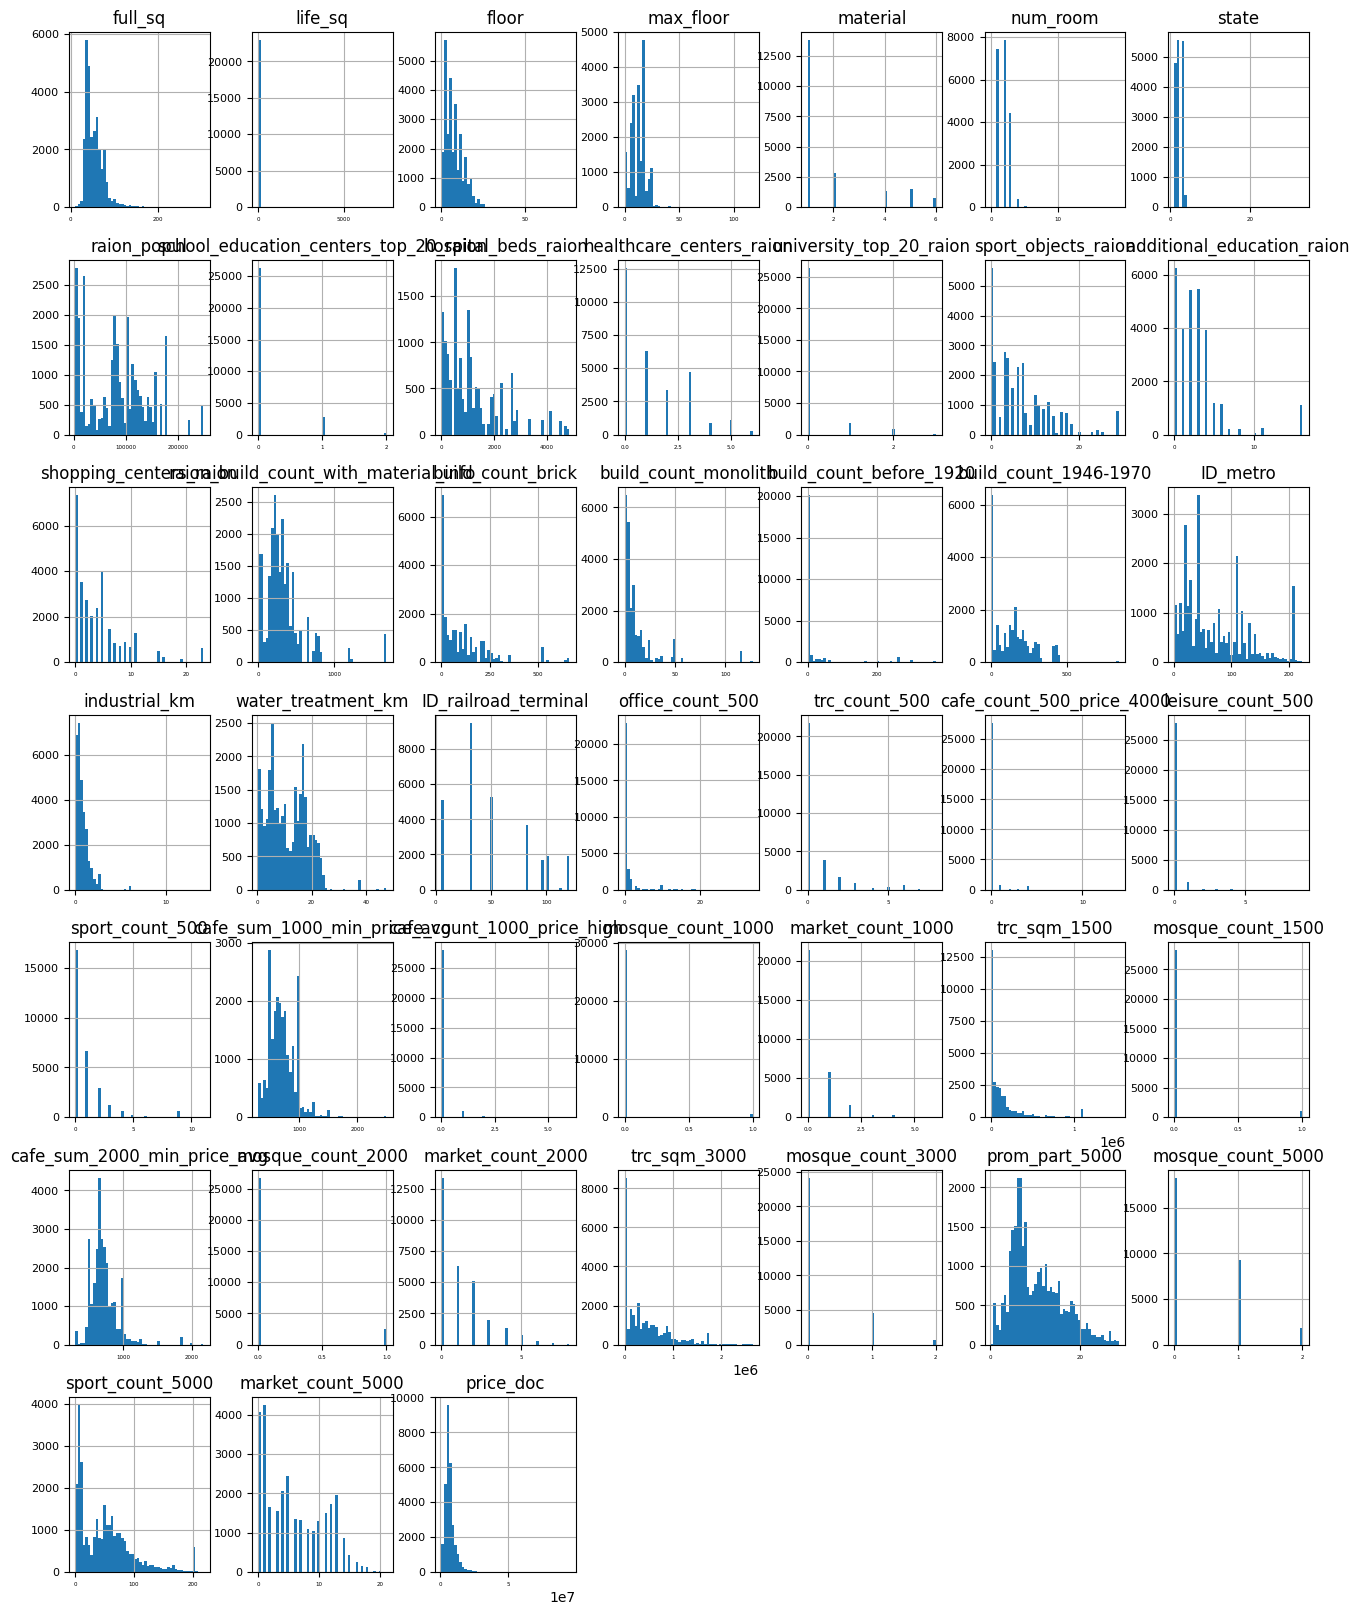

In [395]:
dataset_num = dataset.select_dtypes(include = ['float64', 'int64'])
dataset_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [407]:
#расчет стоимости за 2011-2015
cnt_price_per_year = {}

count_price_per_year = {}
sum_price_per_year = {}

for ind, row in dataset.iterrows():
    year = row['timestamp'][:4]
    if year not in cnt_price_per_year:
        cnt_price_per_year[year] = 0
    if year not in sum_price_per_year:
        sum_price_per_year[year] = 0
    if year not in count_price_per_year:
        count_price_per_year[year] = 0
    count_price_per_year[year]+=row['full_sq']
    sum_price_per_year[year] += row['price_doc']

for i in cnt_price_per_year:
    cnt_price_per_year[i] = sum_price_per_year[i]/count_price_per_year[i]
    
new_df = pd.DataFrame.from_dict([cnt_price_per_year])
new_df.head()

,2011,2012,2013,2014,2015
0,134491.727705,125118.588875,127596.440622,139532.103698,142681.643914


## Создание и обучение модели

In [361]:
def split_dataset(dataset, test_ratio=0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset)
print("{} примеров для тренировки, {} примеров для теста.".format(len(train_ds_pd), len(test_ds_pd)))

20453 примеров для тренировки, 8799 примеров для теста.


In [408]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

In [364]:
tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
model.fit(train_ds, verbose=1)

Use /tmp/tmppjdnlaks as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.112785. Found 20453 examples.
Training model...


[INFO 24-03-30 19:28:49.4298 UTC kernel.cc:1233] Loading model from path /tmp/tmppjdnlaks/model/ with prefix cb7c22216e2d4a5c
[INFO 24-03-30 19:28:58.6657 UTC decision_forest.cc:660] Model loaded with 300 root(s), 1341526 node(s), and 60 input feature(s).
[INFO 24-03-30 19:28:58.6658 UTC abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-03-30 19:28:58.6659 UTC kernel.cc:1061] Use fast generic engine


Model trained in 0:05:00.679312
Compiling model...
Model compiled.


##  Оценка и сохранение модели

In [368]:
model.compile(metrics=["mse"])
evaluation = model.evaluate(test_ds, return_dict=True)
print(evaluation['mse'] ** 0.5)

9/9 [==============================] - 2s 181ms/step - loss: 0.0000e+00 - mse: 4647649542144.0000
2155840.797031172


In [370]:
inspector = model.make_inspector()
inspector.evaluation()

Evaluation(num_examples=20453, accuracy=None, loss=None, rmse=2143075.2714203764, ndcg=None, aucs=None, auuc=None, qini=None)

In [ ]:
model.save('../models/model1')

## Анализ модели

In [409]:
print(f"Доступные варианты анализа:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

Доступные варианты анализа:
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 NUM_AS_ROOT
	 SUM_SCORE


In [372]:
inspector.variable_importances()["INV_MEAN_MIN_DEPTH"]

[("full_sq" (1; #18), 0.3406310958968899),
 ("sub_area" (4; #52), 0.26367395871171995),
 ("num_room" (1; #36), 0.13804323223508433),
 ("life_sq" (1; #24), 0.10880352634806455),
 ("sport_count_5000" (1; #49), 0.10821763590118666),
 ("timestamp" (4; #54), 0.0979003318614268),
 ("trc_sqm_3000" (1; #57), 0.08883671258798143),
 ("raion_popul" (1; #45), 0.0841157601177662),
 ("max_floor" (1; #29), 0.0799404945207819),
 ("sport_objects_raion" (1; #50), 0.0785833050841476),
 ("ID_metro" (1; #0), 0.07741109341443288),
 ("water_treatment_km" (1; #60), 0.07684361431940899),
 ("cafe_sum_2000_min_price_avg" (1; #13), 0.07678340349512154),
 ("ecology" (4; #16), 0.07667389694238642),
 ("floor" (1; #17), 0.07635108269251316),
 ("industrial_km" (1; #22), 0.07624914401676029),
 ("prom_part_5000" (1; #40), 0.07617669188636435),
 ("product_type" (4; #39), 0.0759031244870079),
 ("trc_sqm_1500" (1; #56), 0.07539472109559457),
 ("state" (1; #51), 0.07530165386524579),
 ("market_count_5000" (1; #27), 0.074938

In [373]:
inspector.variable_importances()["NUM_NODES"]

[("timestamp" (4; #54), 293601.0),
 ("sub_area" (4; #52), 61161.0),
 ("full_sq" (1; #18), 46015.0),
 ("floor" (1; #17), 22892.0),
 ("industrial_km" (1; #22), 19380.0),
 ("life_sq" (1; #24), 17427.0),
 ("water_treatment_km" (1; #60), 16126.0),
 ("prom_part_5000" (1; #40), 15844.0),
 ("sport_count_5000" (1; #49), 14808.0),
 ("max_floor" (1; #29), 14391.0),
 ("cafe_sum_2000_min_price_avg" (1; #13), 14285.0),
 ("cafe_sum_1000_min_price_avg" (1; #12), 12704.0),
 ("trc_sqm_3000" (1; #57), 11448.0),
 ("trc_sqm_1500" (1; #56), 10668.0),
 ("state" (1; #51), 8414.0),
 ("ID_metro" (1; #0), 8170.0),
 ("num_room" (1; #36), 7754.0),
 ("material" (1; #28), 6842.0),
 ("market_count_5000" (1; #27), 6161.0),
 ("sport_count_500" (1; #48), 4830.0),
 ("raion_popul" (1; #45), 4062.0),
 ("product_type" (4; #39), 3956.0),
 ("market_count_2000" (1; #26), 3489.0),
 ("ecology" (4; #16), 3407.0),
 ("build_count_brick" (1; #8), 3085.0),
 ("trc_count_500" (1; #55), 3083.0),
 ("build_count_1946-1970" (1; #6), 3036.0

In [168]:
inspector.variable_importances()["NUM_NODES"]

[("total_meters" (1; #11), 34.0), ("district" (4; #4), 1.0)]

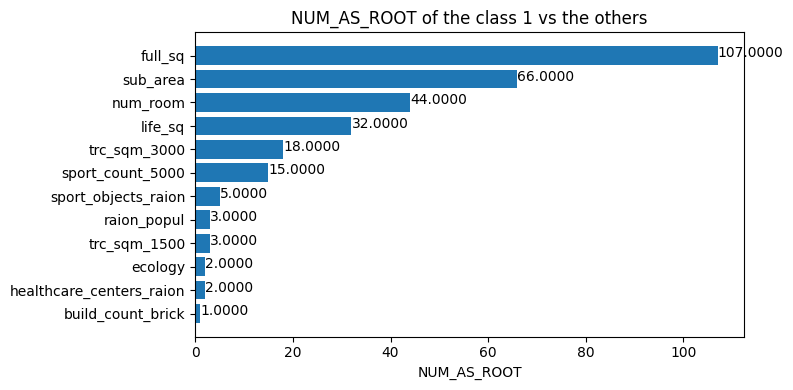

In [393]:
plt.figure(figsize=(8, 4))

variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

feature_names = [vi[0].name for vi in variable_importances[:12]]
feature_importances = [vi[1] for vi in variable_importances[:12]]

feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title(variable_importance_metric + " of the class 1 vs the others")
plt.tight_layout()
plt.show()